In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from scipy.optimize import minimize

## Heat input function

In [43]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

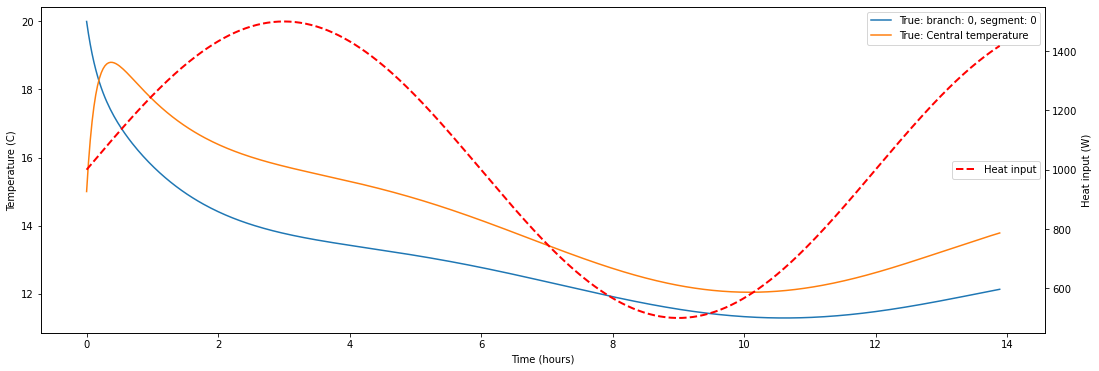

In [44]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
T_out = 10
heatinput = 1000
iterations = 500
# Initialise class with system parameters
sys_nd = model_ND('True', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e4, iterations+1)
Ts_true, Qs = sys_nd.run(times=times, func_Q_in=func_Q_in)
fig, ax = sys_nd.plot()

### Note on loss function
> The losses between model and true temperature of nodes are combined into a total loss, and this total loss is minimised. We might have better success by estimating parameters in individual segments first?

> We might be able to use the max rate of change of temperature of a particular node to provide initial guesses/bounds on thermal conductivity

In [45]:
def loss(params, method='mse'):
    
    # This loss function needs to be a lot faster as it will be called many times by scipy minimize
    
    T_out = 10
#     k_est, c_est, T_est = params
    k1, k2, c1, c2, T1, T2 = params
    
    k_est = np.array([k1,k2]).reshape(1,-1)
    c_est = np.array([c1,c2]).reshape(1,-1)
    T_est = np.array([T1,T2]).reshape(1,-1)
    
    times = np.linspace(0, 5e4, iterations+1)
    T_out = np.array(T_out).reshape(-1,1)
    Ts = np.empty(shape=(len(times), 1, 2))
    Ts[0] = T_est
    Q_in = 1000
    
    dtimes = np.diff(times)
    for i in range(len(times)-1):
        
        heat_flux = np.diff(np.hstack((T_est,T_out)))*k_est
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        T_est[:, 1:] += ( net_heat_flux / c_est[:,1:] ) * dtimes[i]
        
        # update central node
        T_est[:, 0] += ( (heat_flux[:,0] + Q_in) / c_est[:,0] ).sum() * dtimes[i]
    
        Ts[i+1] = T_est

    Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
    
    if method=='mse':
        # mean square error
        error = np.mean((Ts_true - Ts) ** 2)
    elif method=='mad':
        # mean absolute deviation
        error = np.mean(abs(Ts_true-Ts))
    elif method=='lae':
        # least absolute error
        error = np.sum(abs(Ts_true-Ts))
    elif method=='sse':
        # sum of squares error
        error = np.sum((Ts_true - Ts) ** 2)
    else:
        raise ValueError('Method not supported')
    
    return error

In [46]:
# Initial guesses for scipy.optimize.minimize
k0 = [900.0, 400.0]
c0 = [7e5, 1e6]
T0 = [16.0, 19.0]
initial_params = np.array([*k0, *c0, *T0])

# Testing different loss functions

#### Mean square error

	Initial			Estimated		Actual
k1:	900.00000		900.01518		800.00000
k2:	400.00000		400.16992		500.00000
c1:	700000.00000		700000.00006		600000.00000
c2:	1000000.00000		1000000.00000		2500000.00000
T1:	16.00000		16.63553		15.00000
T2:	19.00000		23.34538		20.00000
______________________________________________________
Percentage error:
k1:		12.50%		k2:		19.97%
c1:		16.67%		c2:		60.00%
T1_initial:	10.90%		T2_initial:	16.73%


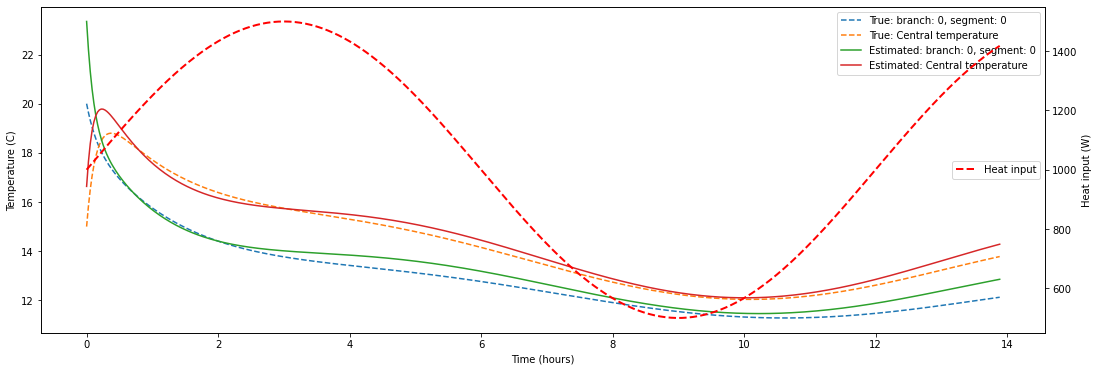

In [47]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Mean absolute deviation

	Initial			Estimated		Actual
k1:	900.00000		900.00876		800.00000
k2:	400.00000		395.88295		500.00000
c1:	700000.00000		700000.00904		600000.00000
c2:	1000000.00000		1000000.00080		2500000.00000
T1:	16.00000		15.00000		15.00000
T2:	19.00000		25.42871		20.00000
______________________________________________________
Percentage error:
k1:		12.50%		k2:		20.82%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	27.14%


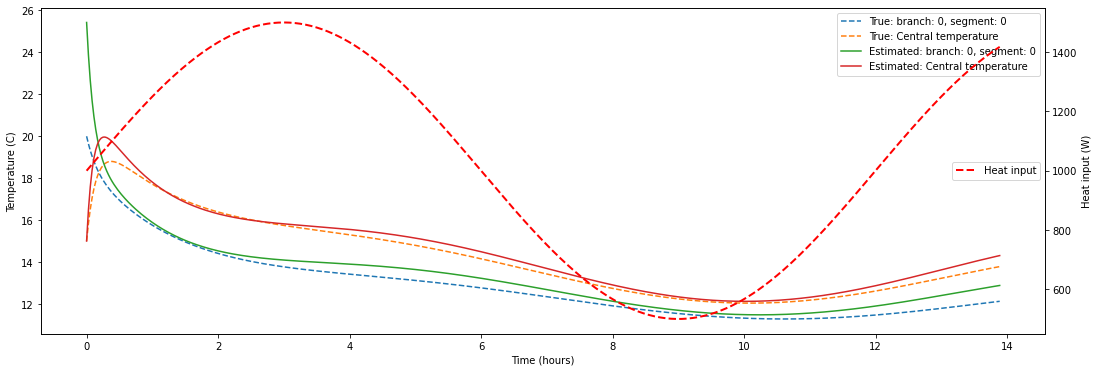

In [48]:
result = minimize(loss, x0=initial_params, args=('mad'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Sum of squares

	Initial			Estimated		Actual
k1:	900.00000		903.61307		800.00000
k2:	400.00000		405.24444		500.00000
c1:	700000.00000		700000.74225		600000.00000
c2:	1000000.00000		1000000.59485		2500000.00000
T1:	16.00000		16.68352		15.00000
T2:	19.00000		23.42148		20.00000
______________________________________________________
Percentage error:
k1:		12.95%		k2:		18.95%
c1:		16.67%		c2:		60.00%
T1_initial:	11.22%		T2_initial:	17.11%


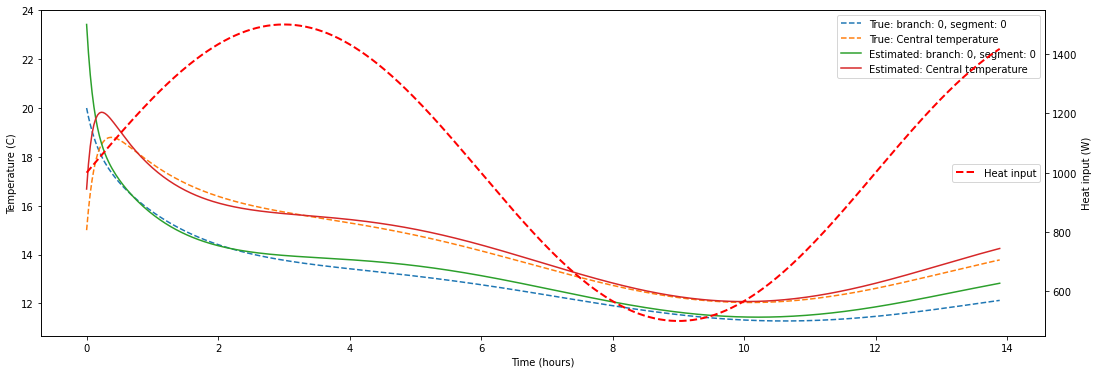

In [49]:
result = minimize(loss, x0=initial_params, args=('sse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Least absolute error

	Initial			Estimated		Actual
k1:	900.00000		903.55442		800.00000
k2:	400.00000		394.72263		500.00000
c1:	700000.00000		700000.43444		600000.00000
c2:	1000000.00000		1000000.00270		2500000.00000
T1:	16.00000		14.99969		15.00000
T2:	19.00000		25.39119		20.00000
______________________________________________________
Percentage error:
k1:		12.94%		k2:		21.06%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	26.96%


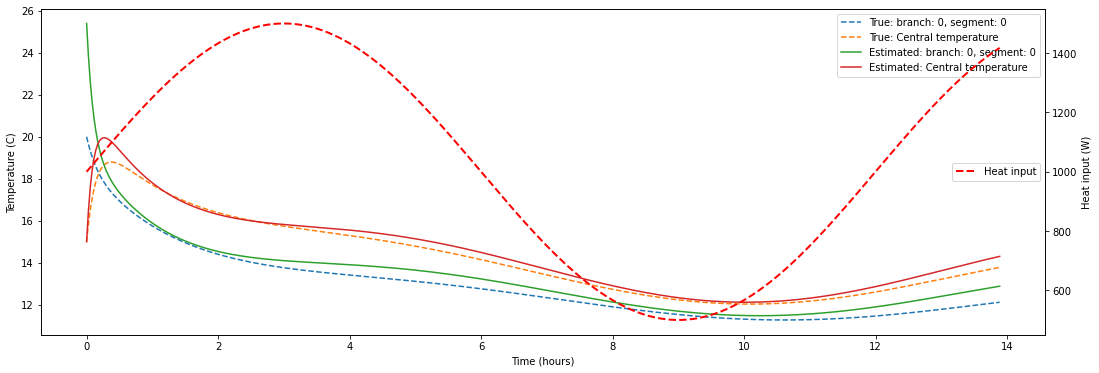

In [50]:
result = minimize(loss, x0=initial_params, args=('lae'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

# Evaluating training
### Tolerance

In [51]:
from time import time
frac_errors = []
losses = []
duration = []
tolerances = [1e-3, 1e-5, 1e-10, 1e-13, 1e-15, 1e-18, 1e-20, 1e-23]
for tolerance in tolerances:
    start = time()
    result = minimize(loss, x0=initial_params, tol=tolerance, args=('mse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    end = time()
    
    k_est, c_est, T_est = result['x'].reshape((3,2))
    sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
    Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)
    frac_error = abs((result['x'] - true_params)/true_params * 100)
    
    duration.append((end-start)/60.0)
    losses.append(loss(result['x']))
    frac_errors.append(frac_error)

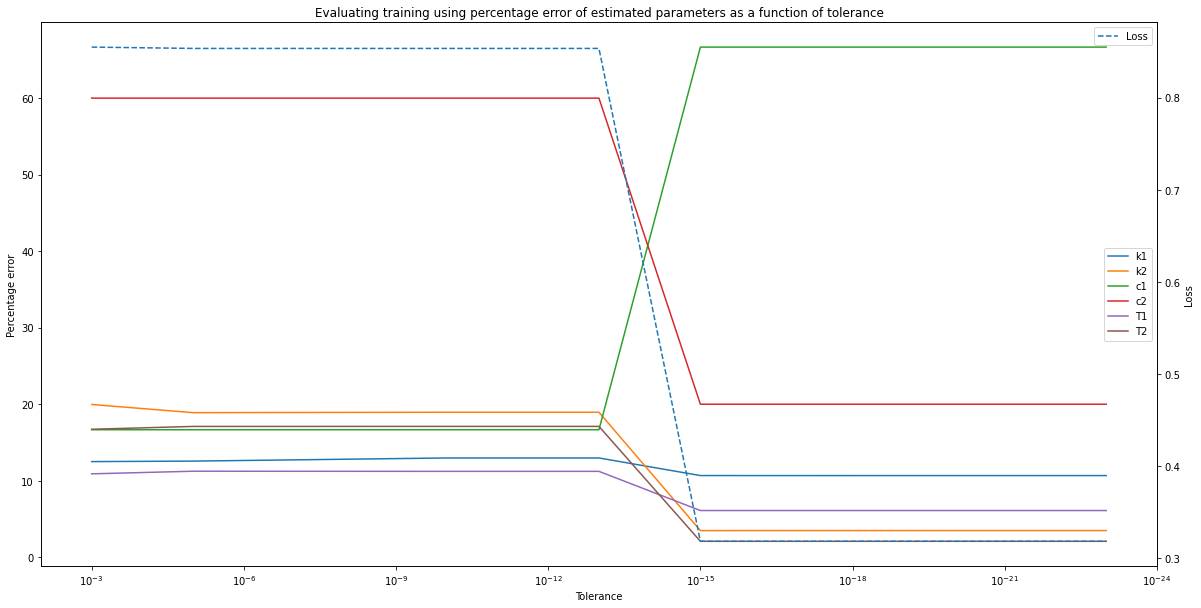

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(tolerances, np.array(frac_errors))
ax2 = ax.twinx()
ax2.plot(tolerances, losses, label='Loss', ls='--')
ax.set(xscale='log', xlabel='Tolerance', ylabel='Percentage error', title='Evaluating training using percentage error of estimated parameters as a function of tolerance')
ax2.set(ylabel='Loss')
# ax.title()
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax2.legend()
ax.invert_xaxis()

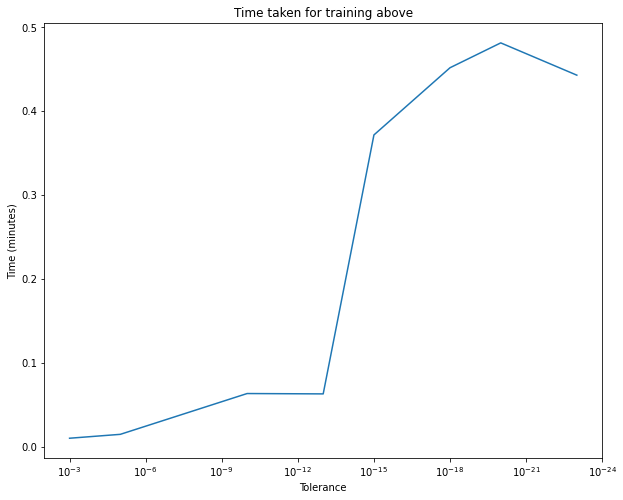

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(tolerances, duration)
ax.set(xscale='log', xlabel='Tolerance', ylabel='Time (minutes)', title='Time taken for training above')
ax.invert_xaxis()

### Max iterations

In [54]:
from time import time
frac_errors = []
losses = []
duration = []
max_iters = [1e2, 1e3, 1e4, 1e5, 1e6]
for max_iter in max_iters:
    start = time()
    result = minimize(loss, x0=initial_params, options={'maxiter':max_iter}, args=('mse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    end = time()
    
    k_est, c_est, T_est = result['x'].reshape((3,2))
    sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
    Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)
    frac_error = abs((result['x'] - true_params)/true_params * 100)
    
    duration.append((end-start)/60.0)
    losses.append(loss(result['x']))
    frac_errors.append(frac_error)

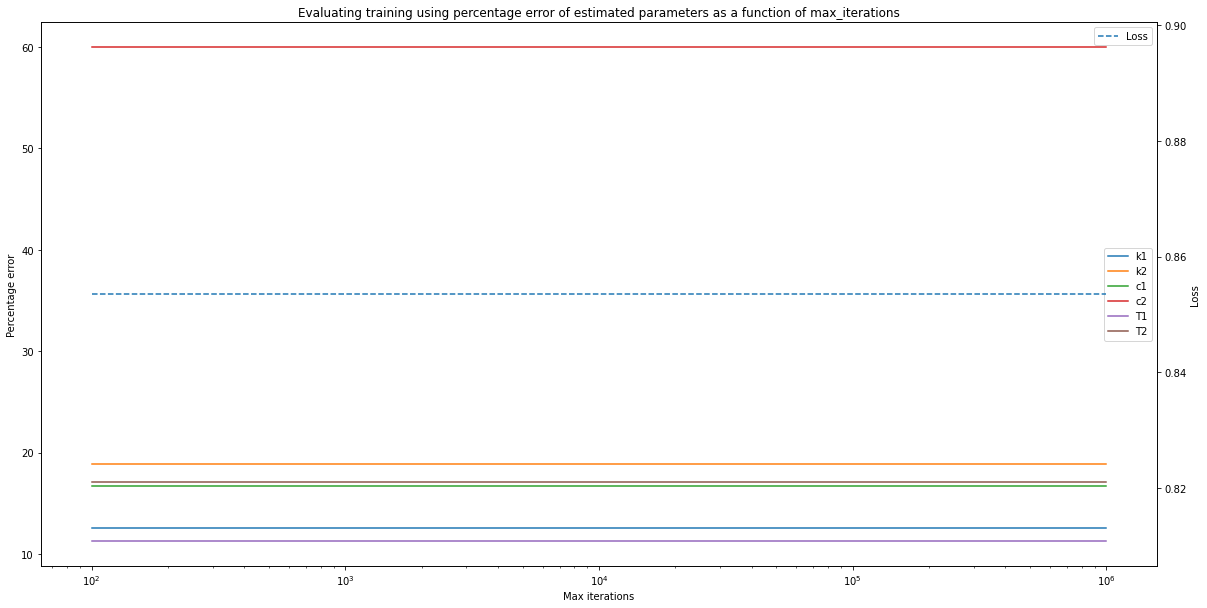

In [55]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(max_iters, np.array(frac_errors))
ax2 = ax.twinx()
ax2.plot(max_iters, losses, label='Loss', ls='--')
ax.set(xscale='log', xlabel='Max iterations', ylabel='Percentage error', title='Evaluating training using percentage error of estimated parameters as a function of max_iterations')
ax2.set(ylabel='Loss')
# ax.title()
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax2.legend()

It appears that increasing max iterations does not improve training.

[None,
 Text(0.5, 0, 'Max iterations'),
 Text(0, 0.5, 'Time (minutes)'),
 Text(0.5, 1.0, 'Time taken for training above')]

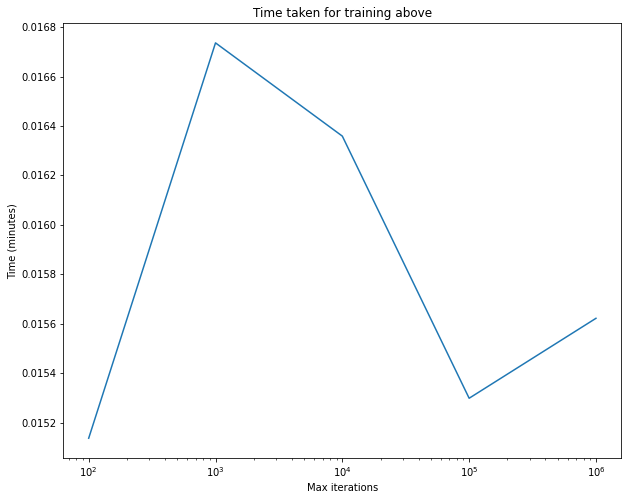

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(max_iters, duration)
ax.set(xscale='log', xlabel='Max iterations', ylabel='Time (minutes)', title='Time taken for training above')